In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

from utils import pattern_utils

In [100]:
n_cpus = 4

In [101]:
class modern_hopfield():
  
  func_type = "Polyn"
  def __init__(self, N: int):
    """
    `N`: number of neurons of the network
    """
    self.N = N
    self.memory_matrix = np.zeros(shape=(1,N))
    return
  
  def add_pattern(self, p: np.ndarray):
    """
    `p`: pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.hstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    `p`: input pattern  \n
    `epochs`: maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def _update_rule(self, sigma: np.ndarray):
    """
    `sigma`: vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)
  
  n=3
  def _F(self, x):
    """
    Energy function used in the update rule. \n
    Different types of function:
    - `Polyn`: polynomial function of order n
    - `RePn`: rectified polynomial function of order n
    """
    match self.func_type:
      case "Polyn":
        return x**self.n
      case "RePn":
        return np.maximum(0, x**self.n)
  


# Testing

## Corruption

In [102]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
steps = 11
epochs = 100


In [103]:
def corruption_analysis(corruption_quantity):

  model = modern_hopfield(pattern_lenght)
  patterns = pattern_utils.generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
  model.add_pattern(patterns)

  correctly_identified = []
  for q in corruption_quantity:
    corrupted = pattern_utils.corrupt_patterns(patterns=patterns, q=q, corruption_type="Flip")

    c_id = 0 
    for i, c in enumerate(corrupted):
      r = model.retrieve_pattern(c, epochs=epochs)
      if np.array_equal(r, patterns[i]): 
        c_id += 1
    correctly_identified.append(c_id)
    # print(f"Corruption quantity {q} | Correcly identified : {c_id}")
  return np.array(correctly_identified)

In [104]:
corruption_quantity = np.array([np.linspace(0, 1, steps)]*n_cpus)
pool = Pool(n_cpus)
results = pool.map(corruption_analysis, corruption_quantity)

In [105]:
print(results)

[array([100, 100, 100,  75,  13,   0,  18,  87, 100, 100, 100]), array([100, 100, 100,  75,  13,   0,  18,  87, 100, 100, 100]), array([100, 100, 100,  75,  13,   0,  18,  87, 100, 100, 100]), array([100, 100, 100,  75,  13,   0,  18,  87, 100, 100, 100])]


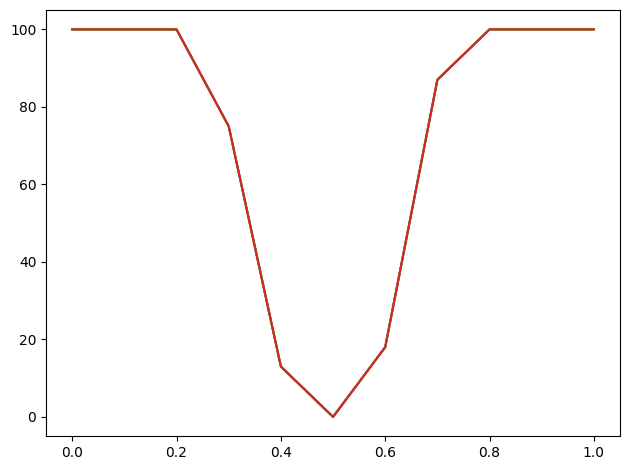

In [106]:
fig, ax = plt.subplots()

for r in results:
  ax.plot(np.linspace(0,1,steps), r)

fig.tight_layout()